**Installing Libraries**

In [ ]:
!pip install opencv-python dlib

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2


--2024-05-20 15:51:30--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  44.1MB/s    in 1.4s    

2024-05-20 15:51:31 (44.1 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
uploaded = files.upload

**Bar Graph Showing Count of Real and Fake Images**

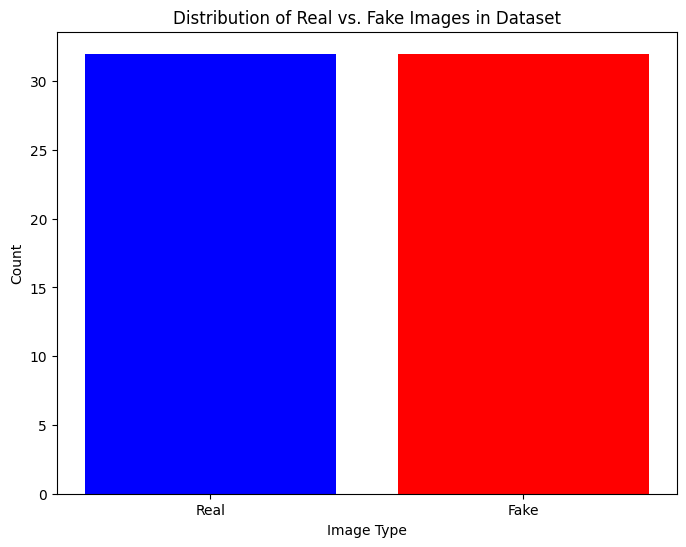

In [5]:
import matplotlib.pyplot as plt

# Count the number of real and fake images in the dataset
num_real = len('/content/drive/MyDrive/Data/Real')
num_fake = len('/content/drive/MyDrive/Data/Fake')

# Plotting the bar graph
labels = ['Real', 'Fake']
counts = [num_real, num_fake]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['blue', 'red'])
plt.title('Distribution of Real vs. Fake Images in Dataset')
plt.xlabel('Image Type')
plt.ylabel('Count')
plt.show()


**Preprocessing and Training**

In [ ]:

import cv2
import dlib
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Initialize the face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor_path = '/content/shape_predictor_68_face_landmarks.dat'  # Path to the shape predictor file
predictor = dlib.shape_predictor(predictor_path)

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) > 0:
        face = faces[0]
        landmarks = predictor(gray, face)

        left_eye = np.array([(landmarks.part(36).x, landmarks.part(36).y), (landmarks.part(37).x, landmarks.part(37).y),
                             (landmarks.part(38).x, landmarks.part(38).y), (landmarks.part(39).x, landmarks.part(39).y),
                             (landmarks.part(40).x, landmarks.part(40).y), (landmarks.part(41).x, landmarks.part(41).y)])
        right_eye = np.array([(landmarks.part(42).x, landmarks.part(42).y), (landmarks.part(43).x, landmarks.part(43).y),
                              (landmarks.part(44).x, landmarks.part(44).y), (landmarks.part(45).x, landmarks.part(45).y),
                              (landmarks.part(46).x, landmarks.part(46).y), (landmarks.part(47).x, landmarks.part(47).y)])
        nose = np.array([(landmarks.part(27).x, landmarks.part(27).y), (landmarks.part(28).x, landmarks.part(28).y),
                         (landmarks.part(29).x, landmarks.part(29).y), (landmarks.part(30).x, landmarks.part(30).y)])
        face_dim = (face.right() - face.left(), face.bottom() - face.top())

        return left_eye, right_eye, nose, face_dim
    else:
        return None, None, None, None

def load_and_preprocess_images(folder):
    images = []
    features = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img_resized = cv2.resize(img, (128, 128))
            left_eye, right_eye, nose, face_dim = extract_features(img)
            if left_eye is not None:
                features.append((left_eye, right_eye, nose, face_dim))
                images.append(img_resized)
    return np.array(images), features

# Specify paths to the directories containing real and fake images
real_directory = '/content/drive/MyDrive/Data/Real'
fake_directory = '/content/drive/MyDrive/Data/Fake'

# Load and preprocess real and fake images
real_images, real_features = load_and_preprocess_images(real_directory)
fake_images, fake_features = load_and_preprocess_images(fake_directory)

# Create labels
real_labels = np.ones(len(real_images))
fake_labels = np.zeros(len(fake_images))

# Concatenate images and labels
X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)

# Normalize pixel values
X = X / 255.0

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Save the trained model in the recommended Keras format
model.save('/content/drive/MyDrive/trained_model.keras')

Epoch 1/10
16/16 [==============================] - 16s 791ms/step - loss: 0.8330 - accuracy: 0.6524 - val_loss: 0.6270 - val_accuracy: 0.7091
Epoch 2/10
16/16 [==============================] - 14s 840ms/step - loss: 0.5868 - accuracy: 0.7195 - val_loss: 0.6785 - val_accuracy: 0.7091
Epoch 3/10
16/16 [==============================] - 14s 910ms/step - loss: 0.5789 - accuracy: 0.7195 - val_loss: 0.6109 - val_accuracy: 0.7091
Epoch 4/10
16/16 [==============================] - 15s 925ms/step - loss: 0.5382 - accuracy: 0.7297 - val_loss: 0.6009 - val_accuracy: 0.7091
Epoch 5/10
16/16 [==============================] - 14s 893ms/step - loss: 0.5022 - accuracy: 0.7500 - val_loss: 0.6286 - val_accuracy: 0.5636
Epoch 6/10
16/16 [==============================] - 16s 999ms/step - loss: 0.4427 - accuracy: 0.7967 - val_loss: 0.6479 - val_accuracy: 0.6727
Epoch 7/10
16/16 [==============================] - 14s 908ms/step - loss: 0.3720 - accuracy: 0.8232 - val_loss: 0.6366 - val_accuracy: 0.6545

In [ ]:
import cv2
import dlib
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the face detector and landmark predictor
detector = dlib.get_frontal_face_detector()
predictor_path = '/content/shape_predictor_68_face_landmarks.dat'  # Path to the shape predictor file
predictor = dlib.shape_predictor(predictor_path)

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) > 0:
        face = faces[0]
        landmarks = predictor(gray, face)

        left_eye = np.array([(landmarks.part(36).x, landmarks.part(36).y), (landmarks.part(37).x, landmarks.part(37).y),
                             (landmarks.part(38).x, landmarks.part(38).y), (landmarks.part(39).x, landmarks.part(39).y),
                             (landmarks.part(40).x, landmarks.part(40).y), (landmarks.part(41).x, landmarks.part(41).y)])
        right_eye = np.array([(landmarks.part(42).x, landmarks.part(42).y), (landmarks.part(43).x, landmarks.part(43).y),
                              (landmarks.part(44).x, landmarks.part(44).y), (landmarks.part(45).x, landmarks.part(45).y),
                              (landmarks.part(46).x, landmarks.part(46).y), (landmarks.part(47).x, landmarks.part(47).y)])
        nose = np.array([(landmarks.part(27).x, landmarks.part(27).y), (landmarks.part(28).x, landmarks.part(28).y),
                         (landmarks.part(29).x, landmarks.part(29).y), (landmarks.part(30).x, landmarks.part(30).y)])
        face_dim = (face.right() - face.left(), face.bottom() - face.top())

        return left_eye, right_eye, nose, face_dim
    else:
        return None, None, None, None

def load_and_preprocess_images(folder):
    images = []
    features = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img_resized = cv2.resize(img, (128, 128))
            left_eye, right_eye, nose, face_dim = extract_features(img)
            if left_eye is not None:
                features.append((left_eye, right_eye, nose, face_dim))
                images.append(img_resized)
    return np.array(images), features

# Specify paths to the directories containing real and fake images
real_directory = '/content/drive/MyDrive/Data/Real'
fake_directory = '/content/drive/MyDrive/Data/Fake'

# Load and preprocess real and fake images
real_images, real_features = load_and_preprocess_images(real_directory)
fake_images, fake_features = load_and_preprocess_images(fake_directory)

# Create labels
real_labels = np.ones(len(real_images))
fake_labels = np.zeros(len(fake_images))

# Concatenate images and labels
X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)

# Normalize pixel values
X = X / 255.0

# Shuffle the data
X, y = shuffle(X, y, random_state=42)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to your training data
datagen.fit(X_train)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train[0].shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the augmented data
batch_size = 32
epochs = 50
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Save the trained model in the recommended Keras format
model.save('/content/drive/MyDrive/trained_model.keras')


Epoch 1/50
17/17 [==============================] - 25s 1s/step - loss: 1.0523 - accuracy: 0.6563 - val_loss: 0.7122 - val_accuracy: 0.6934
Epoch 2/50
17/17 [==============================] - 18s 1s/step - loss: 0.6091 - accuracy: 0.7223 - val_loss: 0.6186 - val_accuracy: 0.6934
Epoch 3/50
17/17 [==============================] - 19s 1s/step - loss: 0.6211 - accuracy: 0.7126 - val_loss: 0.6151 - val_accuracy: 0.6934
Epoch 4/50
17/17 [==============================] - 18s 1s/step - loss: 0.6097 - accuracy: 0.7126 - val_loss: 0.6325 - val_accuracy: 0.6934
Epoch 5/50
17/17 [==============================] - 18s 1s/step - loss: 0.6132 - accuracy: 0.7165 - val_loss: 0.6141 - val_accuracy: 0.6934
Epoch 6/50
17/17 [==============================] - 19s 1s/step - loss: 0.6087 - accuracy: 0.7146 - val_loss: 0.6183 - val_accuracy: 0.6934
Epoch 7/50
17/17 [==============================] - 18s 1s/step - loss: 0.6122 - accuracy: 0.7146 - val_loss: 0.6151 - val_accuracy: 0.6934
Epoch 8/50
17/17 [==

**Model Evaluation**

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


5/5 - 1s - loss: 0.6142 - accuracy: 0.6934 - 771ms/epoch - 154ms/step
Test Loss: 0.6142241358757019
Test Accuracy: 0.6934306621551514


**Count Real and Fake Images in Training and Test Sets**

In [ ]:
# Count real and fake images in training set
train_real_count = np.sum(y_train == 1)
train_fake_count = np.sum(y_train == 0)

# Count real and fake images in test set
test_real_count = np.sum(y_test == 1)
test_fake_count = np.sum(y_test == 0)


**Visualize Training History**

5/5 [==============================] - 1s 168ms/step


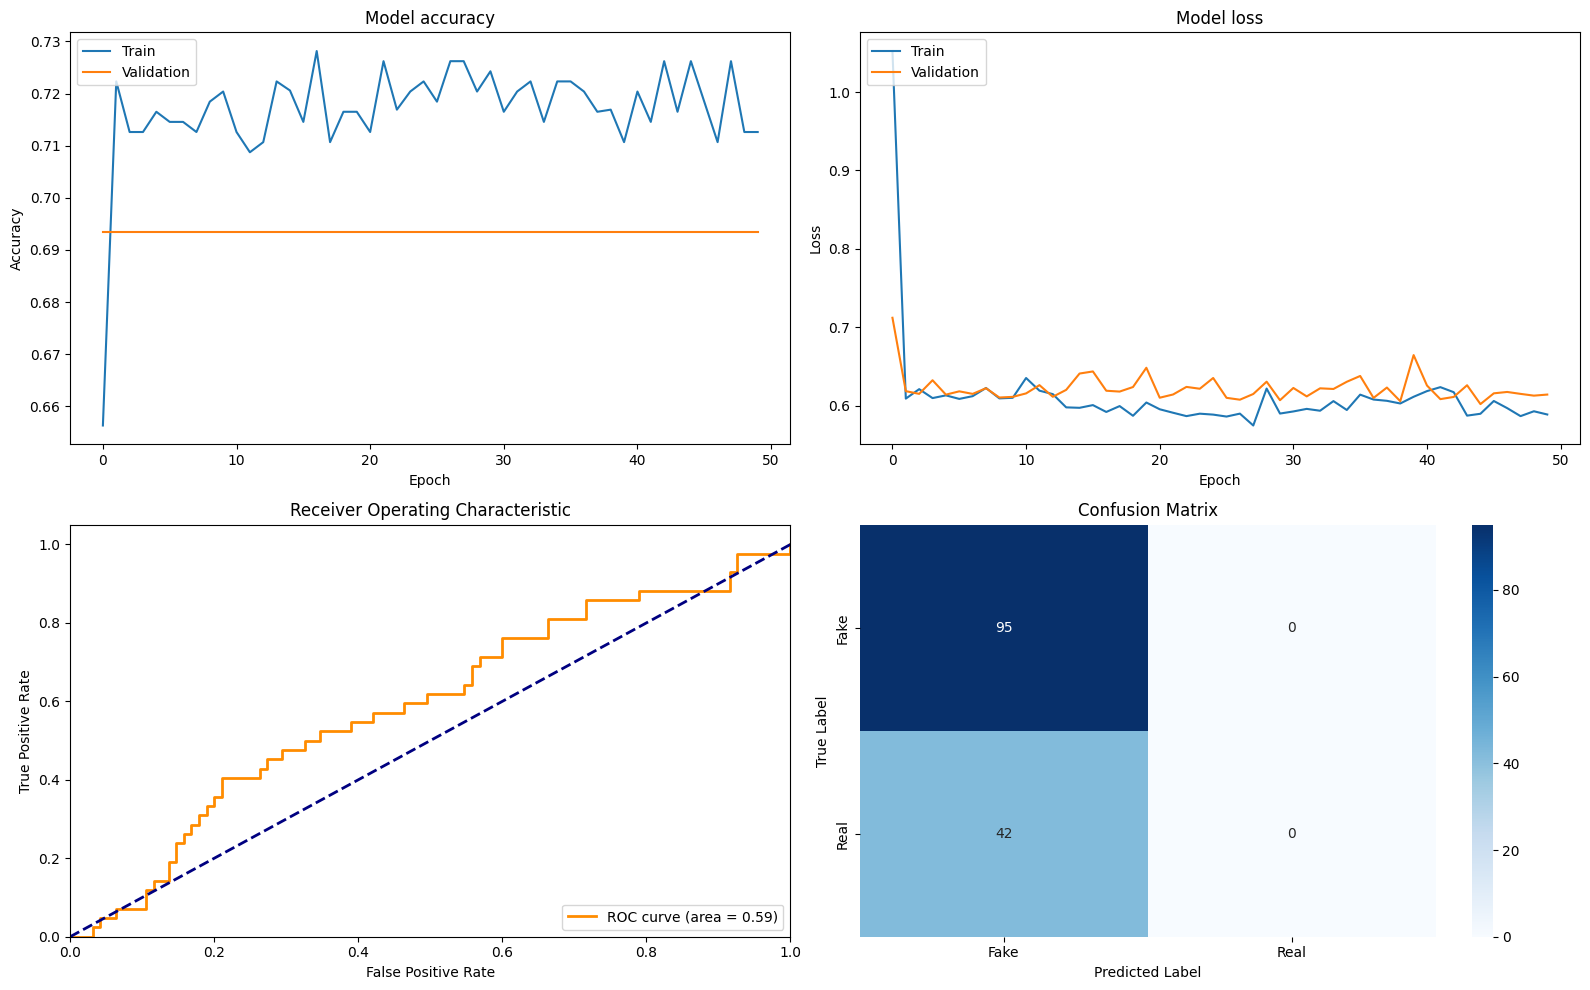

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Plot training & validation accuracy values
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# ROC Curve
y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.subplot(2, 2, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()


**Predict a Image as Real/Fake**


1/1 [==============================] - 0s 87ms/step
Prediction: Fake


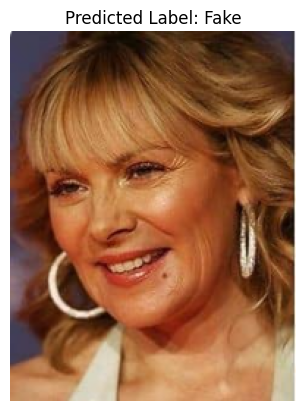

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model_path = '/content/drive/MyDrive/trained_model.keras'
model = load_model(model_path)

# Function to preprocess the input image
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Resize the image to match the input shape of the model
    image_resized = cv2.resize(image, (128, 128))
    # Normalize pixel values
    image_rescaled = image_resized / 255.0
    # Return the preprocessed image
    return image_rescaled

# Function to make predictions
def predict_image(image_path):
    # Preprocess the input image
    preprocessed_image = preprocess_image(image_path)
    # Reshape the image to match the input shape expected by the model
    input_image = np.expand_dims(preprocessed_image, axis=0)
    # Make predictions using the model
    prediction = model.predict(input_image)
    # The prediction will be a probability, convert it to a binary label
    if prediction[0][0] >= 0.5:
        return "Real"
    else:
        return "Fake"

# Path to the image you want to predict
image_path = '/content/drive/MyDrive/Data/Real/50 real.jpg'

# Generate prediction for the image
prediction_result = predict_image(image_path)
print("Prediction:", prediction_result)
# Display the image
image = cv2.imread(single_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying correctly in matplotlib
plt.imshow(image)
plt.title(f'Predicted Label: {label}')
plt.axis('off')
plt.show()
